## Notebook Bachelor Thesis
This notebook was created during the bachelor thesis called "Utilising impedance measurement to detect muscle contraction"
This notbook was created by Sandro Tobias Müller with the help of Bernhard Hollaus

In [5]:
##################### Imports for the processing of the data ###########################
########################################################################################


import time
import csv
import os
import sys
import re
import serial
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyqtgraph as pg
import tkinter as tk
from scipy import signal
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
from moviepy.editor import *
from moviepy.video.io.preview import preview
from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.editor import VideoFileClip
from PyQt6.QtGui import QIcon, QFont
from PyQt6.QtCore import QDir, Qt, QUrl, QSize
from PyQt6.QtMultimedia import QMediaPlayer
from PyQt6.QtMultimediaWidgets import QVideoWidget
from PyQt6.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QHBoxLayout, QLabel, QWidget, QPushButton, QFileDialog, QSpacerItem, QSizePolicy, QTableWidget, QTableWidgetItem, QAbstractScrollArea
from PyQt6 import QtCore, QtWidgets, QtGui
from pyqtgraph import LegendItem
from IPython.display import clear_output


In [ ]:
################################# Key findings plots ####################################
#########################################################################################
##Description: 
# This code script was used to make a few of the key findings plots which were necassary
# for the writing of the the thessi 
#
############################ by Sandro Tobias Müller ###################################

#########################################################################################
###################################### Functions ########################################
def loadData(): 
    # Prompt the user to select multiple CSV files
    file_paths = filedialog.askopenfilenames()

    # Defining Data Structures
    dtypes = {0: str, 1: str, 2: int}

    for file_path in file_paths:

        df = pd.read_csv(file_path, usecols=[0, 1, 2], dtype=dtypes)
        # Delete every 64th row
        df = df.drop(df.index[::64])

        df = df.drop(df.index[:50])

        Time_SEK = df.iloc[:, 0]
        Time_SEK_HDT = df.iloc[:, 1]
        time_sec_ms = Time_SEK.astype(str) + '.' + Time_SEK_HDT.astype(str)

        time_sec = time_sec_ms.astype(float)
        milliohm = df.iloc[:, 2]
        plot_data(time_sec, milliohm)
    return time_sec, milliohm

def plot_data(time_sec,milliohm):
    #plot
    plt.plot(time_sec, milliohm, color='tab:blue') 
    plt.xlim(4,8)
    
    plt.xlabel("Time/s")
    plt.ylabel("Impedance/mΩ")

    plt.savefig(r"E:\Bachelorarbeit_MedTech_Sandro_Mueller\Python\04.png", format="png")
    plt.show()
#########################################################################################
###################################### Processing #######################################

time_sec, milliohm = loadData(); 




In [ ]:
####################### Electrode placement analysis ####################################
#########################################################################################
##Description: 
# This code was getting created to find the best possible spot to attach the electrodes 
# For more information on where electrodes were placed, look at the pictures
# provided inside the thesis. The placement was picked regarding the most significant 
# change in impedance
#
############################ by Sandro Tobias Müller ###################################

#########################################################################################
###################################### Processing #######################################

# Prompt the user to select multiple CSV files
file_paths = filedialog.askopenfilenames()

# Define line styles and markers
line_styles = ['-', '--', '-.', '-', '-', '--', '-.']  
markers =['^','^','^','o','s','o','o']

# Set figure size and DPI
fig = plt.figure(figsize=(8, 6), dpi=120)

# Loop through each file path
for i, file_path in enumerate(file_paths):
    print(file_path)

    # Defining Data Structures
    dtypes = {0: str, 1: str, 2: int}

    # Import the CSV file as a Pandas DataFrame, selecting only the first 3 columns
    df = pd.read_csv(file_path, usecols=[0, 1, 2], dtype=dtypes)
    # Delete every 64th row
    df = df.drop(df.index[::64])

    df = df.drop(df.index[:50])

    Time_SEK = df.iloc[:, 0]
    Time_SEK_HDT = df.iloc[:, 1]
    time_sec_ms = Time_SEK.astype(str) + '.' + Time_SEK_HDT.astype(str)

    time_sec = time_sec_ms.astype(float)
    milliohm = df.iloc[:, 2]

    ## Filtering
    highpass_cutoff_freq = 0.001
    highpass_sampling_freq = 63
    filter_order = 2 

    # Filter coefficients
    b, a = signal.butter(filter_order, highpass_cutoff_freq / (highpass_sampling_freq / 2),
                          'highpass')

    # Filter signal
    highpass_filtered_signal = signal.filtfilt(b, a, milliohm)

    lowpass_cutoff_freq = 2
    lowpass_sampling_freq = 63
    filter_order = 2 

    # Filter coefficients 
    b, a = signal.butter(filter_order, lowpass_cutoff_freq / (lowpass_sampling_freq/2),
                          'lowpass')

    # Filter signal 
    lowpass_filtered_signal = signal.filtfilt(b, a, highpass_filtered_signal)

    # Get the file name from the file path
    file_name = file_path.split("/")[-1]

    # Plot the data on the same plot with custom line style and marker
    line, = plt.plot(time_sec, lowpass_filtered_signal, label=file_name,
                      linestyle=line_styles[i % len(line_styles)], linewidth=1.5,
                        marker=markers[i % len(markers)], markersize=4, markevery = 20)
    

# Add legend to show file names
plt.legend()

# Add labels to the x-axis and y-axis
plt.xlabel("Time/s")
plt.ylabel("Impedance/mΩ")

# Show the plot
plt.savefig(r"E:\Bachelorarbeit_MedTech_Sandro_Mueller\Eletroden_Setup\
            Electrode_Comparsion.svg", format="svg")
plt.show()


In [ ]:
############################## Processing of the signal ################################
########################################################################################
##Description: 
# The processing of the signal includes the following steps. Cutting, Subtraction of 
# the linear regression, normailisation, filtering and scaling. All of thoses steps can
# be found inside the code and described.
#
############################ by Sandro Tobias Müller ###################################

########################################################################################
################################### Parameter ##########################################
# Highpass parameters 
highpass_cutoff_freq = 0.001 # Cut off frequency 
highpass_sampling_freq = 64 # Sampele rate
filter_order = 2 
# Filter coefficients
b_h, a_h = signal.butter(filter_order, highpass_cutoff_freq / (highpass_sampling_freq / 2),
                          'highpass')


#Lowpass parameters 
lowpass_cutoff_freq = 2
lowpass_sampling_freq = 64
filter_order = 2 
# Filter coefficients 
b_l, a_l = signal.butter(filter_order, lowpass_cutoff_freq / (lowpass_sampling_freq/2),
                         'lowpass' )

#File path to save the indivual CSV file
file_path_save = r"E:\Bachelorarbeit_MedTech_Sandro_Mueller\Data\Training_data\
                Measurements\filtered_cut"

#Scaling csv 
columns_scale = ["ID", "Scale factor"]
scaling_factors = pd.DataFrame(columns=columns_scale)


########################################################################################
##################################### Functions ########################################
## Function to get the max value if wanted for the normalisation
def get_max(file_paths,ques):
    local_maxs = []
    if ques == 'y': # If the input is y then the global max is calculated
        # Loop to import every .csv 
        # Defining Data Structures
        dtypes = {0: str, 1: str, 2: int}
        for i, file_path in enumerate(file_paths):     
            df = pd.read_csv(file_path, usecols=[0, 1, 2], dtype=dtypes)
            # Delete every 64th row
            df = df.drop(df.index[::64])
            # First 50 rows are getting deleted
            df = df.drop(df.index[:50])
            milliohm = df.iloc[:, 2]

            # Find out local max value 
            local_maxs.append(max(milliohm)) 

        #Find out the gloabl max value
        global_max = max(local_maxs)
        print("The highest value in this value is: ", global_max)
        return(global_max)
    else: 
        global_max = input("Please type in your normalization value?") # Pick manually
        return(global_max)

## Scaling of the signal if wanted
def scaling_data(y, file_path, time_sec):
    global scaling_factors
    max_value = max(np.abs(y)) # Get max value
    scaling_factor = 1 if max_value >= 0 else -1 # Determinate scaling factor
    scaled_signal = y / max_value * scaling_factor # Scale the input factor
    
    # Save the scaling factor and scaling operation in the scaling_factors dataframe
    ID = os.path.splitext(os.path.basename(file_path))[0]
    new_row = pd.DataFrame({"ID": [ID], "Scale factor": [scaling_factor]})
    scaling_factors = pd.concat([scaling_factors, new_row], ignore_index=True)

    # Flag for filename change if scaling was applied
    Scale = True
    
    # Plot the scaled values
    plt.figure("Scaling Check")
    plt.plot(time_sec, scaled_signal)
    plt.xlabel("Time/s")
    plt.ylabel("Impedance/mΩ")
    plt.show(block=False)
    time.sleep(1)

    # Input stops the code to validate the scaling
    input("Do you have checked the scaling?")
    plt.close("Scaling Check")
    clear_output(wait=True)

    return scaled_signal, Scale

#########################################################################################
###################################### Processing #######################################
# Prompt the user to select the CSV file
file_paths = filedialog.askopenfilenames()

## Normalization
# Input to decide to get the global mac or pick one by yourself
ques = input("Do you want to get the highest value to normalize? y/n")
global_max = get_max(file_paths,ques)

## main loop
for i, file_path in enumerate(file_paths): 
    ##Iteration print
    print("Iteration for:", file_path)

    ##Defining Data Structure and import indivual .csv's
    dtypes = {0: str,1: str,2: int}
    df = pd.read_csv(file_path, usecols=[0, 1, 2], dtype= dtypes)

    #Remodeling of the data - Command out to get raw data
    df = df.drop(df.index[::64]) # Delea every 64th value
    df = df.drop(df.index[:50]) # First 50 values deleted

    #Definig the structure and merch seconds
    Time_SEK = df.iloc[:,0] 
    Time_SEK_HDT = df.iloc[:,1]
    time_sec_ms = Time_SEK.astype(str) + '.' + Time_SEK_HDT.astype(str)

    #Generate the two final variables
    time_sec = time_sec_ms.astype(float)
    milliohm = df.iloc[:,2]

    # Re-indexing 
    time_sec = time_sec.reset_index(drop = True)
    milliohm = milliohm.reset_index(drop = True)

    # Plot of the cut data
    plt.figure("Cut data / raw data")
    plt.plot(time_sec, milliohm)
    plt.xlabel("Time/s")
    plt.ylabel("Impedance/mΩ")
    plt.legend()
    plt.show(block=False)
    time.sleep(1)

    input("Do you have checked the cut data? ")

    ###Start Preprocsseing Algorhitm
    ## Linear Regression
    model = LinearRegression() 

    # Reshape the time_sec array
    time_sec_reshaped = time_sec.values.reshape(-1, 1)

    #Fit model to the data 
    model.fit(time_sec_reshaped, milliohm)

    # Predict 
    y_pred = model.predict(time_sec_reshaped)

    # Plot of the regression to check it 
    plt.figure("Regression Check")
    plt.scatter(time_sec, milliohm, label="original signal", s=5)
    plt.plot(time_sec, y_pred, color='red', label="Regression Line")
    plt.xlabel("Time/s")
    plt.ylabel("Impedance/mΩ")
    plt.legend()
    plt.show(block=False)
    time.sleep(1)

    input("Do you have checked the regression? ")
    plt.close("Regression Check")
    clear_output(wait=True)
    # Regression is getting subtracted
    lin_y = milliohm - y_pred

    # Plot of the regression subtracted
    plt.figure("Regression subtracted")
    plt.plot(time_sec, lin_y)
    plt.xlabel("Time/s")
    plt.ylabel("Impedance/mΩ")
    plt.legend()
    plt.show(block=False)
    time.sleep(1)

    input("Do you have checked the subtraction? ")

    ## Normalization 
    lin_norm_y = []
    for value in lin_y: 
        lin_norm_y.append(value / global_max)
    
    plt.figure("Normalization Check")
    plt.plot(time_sec, lin_norm_y)
    plt.xlabel("Time/s")
    plt.ylabel("Impedance/mΩ")
    plt.show(block=False) 
    time.sleep(1)

    input("Do you have checked the Normalization?")
    plt.close("Normalization Check")
    clear_output(wait=True)

    ## Filtering of the signal
    # Highpass filtering
    high_y = signal.filtfilt(b_h, a_h, lin_norm_y)

    plt.figure("Filtering Check higpass")
    plt.plot(time_sec, high_y)
    plt.xlabel("Time/s")
    plt.ylabel("Impedance/mΩ")
    plt.show(block=False)
    time.sleep(1)


    #Filter signal 
    low_y = signal.filtfilt(b_l,a_l,high_y)


    ## Plot the data
    plt.figure("Filtering Check lowpass")
    plt.plot(time_sec, low_y)
    plt.xlabel("Time/s")
    plt.ylabel("Impedance/mΩ")
    plt.show(block=False)
    time.sleep(1)

    input("Do you have checked the filtering?")
    plt.close("Filtering Check")
    clear_output(wait=True)

    ## Scaling of the data 
    #Not sure if this is necassary or not 
    low_y, Scale = scaling_data(low_y, file_path, time_sec)

    ### Create data structure to save the csv and prep for the labeling
    # Create a structured numpy array with column titles
    dt = np.dtype([('Time/s', float), ('Impedance/mOhm', float), ('L_nothing',int), 
                   ('L_thumb', int), ('L_index', int), ('L_middle', int), ('L_ring', int),
                     ('L_pinki', int)])
    
    arr = np.zeros((len(time_sec),), dtype=dt)

    # Fill the first two columns with the data from the original lists
    arr['Time/s'] = time_sec
    arr['Impedance/mOhm'] = low_y
    
    saveques = "y" # Can be changed to doesn't save the file
    #saveques = input("Do you want to save the csv file or change anything? y/n")
    if saveques == "y": 
        # ID extractions
        ID = os.path.splitext(os.path.basename(file_path))[0]
        filename = f"Data_PID_{ID}_preproc.csv"
        if Scale:
            filename = f"Data_PID_{ID}_preproc_scale.csv"
            

        # Save the numpy array as a CSV file
        np.savetxt(os.path.join(file_path_save, filename), arr, delimiter=',', fmt='%s',
                    header=','.join(dt.names))

        print("Signal file saved")
    else: 
        print("Start over the programm to save the file")
        sys.exit()
    
# Flag check to save the scaling factor inside the seperate csv for further eval
if Scale:
    print("Save Scale file")
    filename_scale = "Scaling_Factors.csv"
    scaling_factors.to_csv(os.path.join(file_path_save, filename_scale), index=False)


In [ ]:
############################## Cutting of the Video ####################################
########################################################################################
##Description: 
# This code is used to cut the video to be able to synchronise with the data
#
############################ by Sandro Tobias Müller ###################################

#############################################################################################
###################################### Processing ###########################################
# File input
root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename(title="Select Input Video",
                                        filetypes=[("MP4 files", "*.mp4")])

# Generate generic output filename
output_dir = "E:\Bachelorarbeit_MedTech_Sandro_Mueller\Data\Training_data\Viediodata\cuttet"
ID = os.path.splitext(os.path.basename(file_path))[0]
output_filename = f"Video_PID-{ID}.mp4"
output_filepath = os.path.join(output_dir, output_filename)

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open video capture object
cap = cv2.VideoCapture(file_path)

# Create video writer object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_filepath, fourcc, fps, (width, height))

# Define variable for start point selection
selected_start_point = None

# Define font and position for text overlay
font = cv2.FONT_HERSHEY_SIMPLEX
org = (50, 50)
org1 = (50, 80)
font_scale = 1
color = (255, 255, 255)
thickness = 2

# Loop through video frames
while True:
    # Read current frame
    ret, frame = cap.read()

    # Check if end of video reached
    if not ret:
        break

    # Get current frame number
    frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    # Add text overlay with frame number
    cv2.putText(frame, f"Frame: {frame_num}", org, font, font_scale, color, thickness)
    cv2.putText(frame, f"press s to exit loop", org1, font, font_scale, color, thickness)

    # Display current frame and wait for key press
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(0)

    # Use arrow keys to navigate through frames
    if key == 0x270000: # Right arrow forward
        pass
    
    # Exit loop if 's' key is pressed
    if key == ord('s'):
        break

cv2.destroyAllWindows()
start_frame = int(input("Which frame should be the start: "))
end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


# Set video capture to start from desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Calculate number of frames to be written
num_frames = end_frame - start_frame

# Loop through and extract frames
while num_frames > 0:
    # Determine how many frames to read at once (max 100)
    num_frames_to_read = min(num_frames, 100)

    # Read frames from video
    frames = np.empty((num_frames_to_read, height, width, 3), dtype=np.uint8)
    for i in range(num_frames_to_read):
        ret, frame = cap.read()
        if ret:
            frames[i] = frame
        else:
            break

    # Write frames to output video
    for frame in frames:
        if frame is not None:
            out.write(frame)

    # Update remaining number of frames
    num_frames -= num_frames_to_read

# Release video capture, video writer, and destroy windows
cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
################################### Labeling Tool ######################################
########################################################################################
##Description: 
# This tool is getting used to asign the labels to the indivual datapoints. This step
# is crucial for the Macchine Learning. The technique used here is one hot encoding.
#
############################ by Sandro Tobias Müller ###################################
#Information to the used documentation: 
# https://www.pythonguis.com/pyqt6-tutorial/

###########################################################################################
################################## Processing #############################################

class VideoPlayer(QWidget):
    ## Done only has to be included into whole main window
    progressUpdated = pyqtSignal(float)
    currentFrameChanged = pyqtSignal(int)
    framePositionChanged = pyqtSignal(float)
    stateChanged = pyqtSignal(int)
    

    def __init__(self, parent=None):
        super(VideoPlayer, self).__init__(parent)

        self.mediaPlayer = QMediaPlayer()
        

        btnSize = QSize(16, 16)
        videoWidget = QVideoWidget()
        videoWidget.setFixedSize(600, 350)
        self.mediaPlayer.setVideoOutput(videoWidget)

        #Open video button 
        openButton = QPushButton("Open Video")   
        openButton.setToolTip("Open Video File")
        openButton.setStatusTip("Open Video File")
        openButton.setFixedHeight(24)
        openButton.setIconSize(btnSize)
        openButton.setFont(QFont("Noto Sans", 8))
        openButton.setIcon(QIcon.fromTheme("document-open", QIcon("D:/_Qt/img/open.png")))
        openButton.clicked.connect(self.abrir)

        #Play button
        self.playButton = QPushButton()
        self.playButton.setEnabled(False)
        self.playButton.setFixedHeight(24)
        self.playButton.setIconSize(btnSize)
        self.playButton.setIcon(self.style().standardIcon(QStyle.StandardPixmap.SP_MediaPlay))
        self.playButton.clicked.connect(self.play)

        #Playback speed button
        self.speedButton = QPushButton('1.0x')
        self.speedButton.setEnabled(True)
        self.speedButton.setFixedHeight(24)
        self.speedButton.setIconSize(btnSize)
        self.speedButton.setFont(QFont("Noto Sans", 8))
        self.speedButton.clicked.connect(self.changePlaybackSpeed)

        #Viedio slider
        self.positionSlider = QSlider(Qt.Orientation.Horizontal)
        self.positionSlider.setRange(0, 0)
        self.positionSlider.sliderMoved.connect(self.setPosition)

        self.statusBar = QStatusBar()
        self.statusBar.setFont(QFont("Noto Sans", 7))
        self.statusBar.setFixedHeight(14)

        #layout control 
        controlLayout = QHBoxLayout()
        controlLayout.setContentsMargins(0, 0, 0, 0)
        controlLayout.addWidget(openButton)
        controlLayout.addWidget(self.playButton)
        controlLayout.addWidget(self.speedButton)
        controlLayout.addWidget(self.positionSlider)

        layout = QVBoxLayout()
        layout.addWidget(videoWidget)
        layout.addLayout(controlLayout)
        layout.addWidget(self.statusBar)

        self.setLayout(layout)

        #help(self.mediaPlayer)
        self.mediaPlayer.setVideoOutput(videoWidget)
        self.mediaPlayer.playbackStateChanged.connect(self.mediaStateChanged)
        self.mediaPlayer.positionChanged.connect(self.positionChanged)
        self.mediaPlayer.durationChanged.connect(self.durationChanged)
        self.mediaPlayer.errorChanged.connect(self.handleError)
        self.statusBar.showMessage("Ready")

        

    def abrir(self):
        fileName, _ = QFileDialog.getOpenFileName(self, "Select Media",
                ".", "Video Files (*.mp4 *.flv *.ts *.mts *.avi)")

        if fileName != '':
            self.mediaPlayer.setSource(QUrl.fromLocalFile(fileName))
            self.playButton.setEnabled(True)
            self.statusBar.showMessage(fileName)
            self.mediaPlayer.pause()

    def play(self):
        if self.mediaPlayer.playbackState() == QMediaPlayer.PlaybackState.PlayingState:
            self.mediaPlayer.pause()
        else:
            self.mediaPlayer.play()

    def mediaStateChanged(self, state):
        if self.mediaPlayer.playbackState() == QMediaPlayer.PlaybackState.PlayingState:
            self.playButton.setIcon(
                    self.style().standardIcon(QStyle.StandardPixmap.SP_MediaPause))
        else:
            self.playButton.setIcon(
                    self.style().standardIcon(QStyle.StandardPixmap.SP_MediaPlay))
        self.stateChanged.emit(state)

    def positionChanged(self, position):
        self.positionSlider.setValue(position)
        self.currentFrameChanged.emit(position)
        self.framePositionChanged.emit(position)
        

    def durationChanged(self, duration):
        self.positionSlider.setRange(0, duration)

    def setPosition(self, position):
        self.mediaPlayer.setPosition(position)

    def handleError(self):
        self.playButton.setEnabled(False)
        self.statusBar.showMessage("Error: " + self.mediaPlayer.errorString())

    def changePlaybackSpeed(self): 
        speed = self.mediaPlayer.playbackRate()
        if speed == 1.0:
            self.mediaPlayer.setPlaybackRate(0.5)
            self.speedButton.setText('0.5x')
        elif speed == 0.5:
            self.mediaPlayer.setPlaybackRate(0.10)
            self.speedButton.setText('0.10x') 
        else:
            self.mediaPlayer.setPlaybackRate(1.0)
            self.speedButton.setText('1.0x')
    
    def updateVLinePosition(self, position):
        if self.mediaPlayer.playbackState() == QMediaPlayer.PlaybackState.PlayingState:
            seconds = position / 1000  # convert position from milliseconds to seconds
            self.framePositionChanged.emit(seconds)
            

class PlotWidget(QWidget):
    csvSelected = QtCore.pyqtSignal(str)
    vlinePositionChanged = QtCore.pyqtSignal(float)

    def __init__(self, parent=None):
        super().__init__(parent)
        self.setFixedSize(600, 350)
        self.plotWidget = pg.PlotWidget(self)
        self.plotWidget.move(0, 0)
        self.plotWidget.setFixedSize(600, 350)
        self.plotWidget.setBackground('w')
        self.plotWidget.setLabel('left', 'Impedance/mΩ')
        self.plotWidget.setLabel('bottom', 'Time/s')
        self.plotWidget.setTitle('Preprocessed signal')

        self.browseButton = QPushButton('Select .csv', self)
        self.browseButton.move(10, 10)
        self.browseButton.setFixedWidth(100)
        self.browseButton.clicked.connect(self.browseFile)
        self.browseButton.raise_()  # set z-order of browseButton to be higher 

        

        #Create Vertical line 
        self.vpltline = pg.InfiniteLine(pos=0, angle=90, movable=False)
        self.vpltline.setZValue(10)

        self.data = None
   

    def browseFile(self):
        filePath, _ = QFileDialog.getOpenFileName(self, 'Open CSV', os.getenv('HOME'),
                                                   'CSV(*.csv)')
        if filePath != '':
            self.plotData(filePath)
            self.browseButton.hide()
            self.csvSelected.emit(filePath)  # emit signal with file path

    def plotData(self, filePath):
        data = pd.read_csv(filePath)
        self.data = data
        self.plotWidget.clear()
        self.plotWidget.plot(data['# Time/s'], data['Impedance/mOhm'], pen='g')
        self.plotWidget.addItem(self.vpltline)
    
    @QtCore.pyqtSlot(float)
    def updateVlinePosition(self, milliseconds):
        seconds = float((milliseconds / 1000)) 
        if self.data is not None:
            time_col = self.data['# Time/s']
            idx = np.abs(time_col - seconds).argmin()
            x_value = time_col[idx]
            self.vpltline.setValue(x_value)

class LabelWidget(QWidget):
    def __init__(self, player, parent=None):
        super().__init__(parent)

        self.player = player
        self.current_button = None
        self.setFixedSize(600, 500)
        self.player.stateChanged.connect(self.handle_media_status)
        self.label = QLabel() 
        
        self.vertical_lines = []  
        
        
        self.previous_timestamp = None
        self.previous_button_label = None  

        # Create grid layout with six rows and one column
        layout = QGridLayout()
        layout.setSpacing(10)
        layout.setContentsMargins(10, 10, 10, 10)
        layout.setRowStretch(0, 2)
        layout.setRowStretch(1, 1)
        layout.setRowStretch(2, 1)
        layout.setRowStretch(3, 1)
        layout.setRowStretch(4, 1)
        layout.setRowStretch(5, 1)
        

        self.y_Labels = ['L_nothing','L_thumb','L_index','L_middle','L_ring','L_pinki']
        self.button_label_to_index = {label: index for index,
                                       label in enumerate(self.y_Labels)}  
        self.plotWidgets = []
        self.data = None 

        for i in range(6):
            plotWidget = pg.PlotWidget()
            plotWidget.setBackground('w')
            plotWidget.showGrid(x=True, y=True)
            plotWidget.setTitle(self.y_Labels[i])
            layout.addWidget(plotWidget, i, 0)
            self.plotWidgets.append(plotWidget)
        
        self.setLayout(layout)

    def handle_media_status(self, status):
        if self.player.mediaPlayer.mediaStatus() == QMediaPlayer.MediaStatus.EndOfMedia:
            self.video_finished()

    def video_finished(self):
        print("Video finished!")

    def add_vertical_line(self, time, button_label):
        plot_index = self.button_label_to_index[button_label]
        plotWidget = self.plotWidgets[plot_index]
        vertical_line = pg.InfiniteLine(time, angle=90, pen=pg.mkPen('r', width=1))
        plotWidget.addItem(vertical_line)
        self.vertical_lines.append(vertical_line)

        if self.previous_timestamp is not None and self.previous_button_label is not None:
            if self.previous_button_label != button_label:  
                previous_plot_index = self.button_label_to_index[self.previous_button_label]
                self.draw_filled_square(self.previous_timestamp, time, previous_plot_index)

    def draw_filled_square(self, start_time, end_time, plot_index):
        plotWidget = self.plotWidgets[plot_index]
        start_time = max(plotWidget.getAxis('bottom').range[0], start_time)
        end_time = min(plotWidget.getAxis('bottom').range[1], end_time)

        print(f"start_time: {start_time}, end_time: {end_time}")

        square = QGraphicsRectItem(start_time, 0, end_time - start_time, 1)
        square.setBrush(QColor('green'))
        square.setPen(QPen(Qt.PenStyle.NoPen))
        plotWidget.addItem(square)

    def loadData(self, filePath):
        self.data = pd.read_csv(filePath)  # Assign the read CSV data to the data instance variable
        self.filePath = filePath
        max_time = self.data['# Time/s'].max()
        max_time = max_time + 2 #add two seconds space 
        # fill in the data
        for i in range(6):
            x = self.data['# Time/s']  
            y = self.data[self.y_Labels[i]]
            curve = self.plotWidgets[i].plot(x, y, pen='b', stepMode='left')

            self.plotWidgets[i].setYRange(0,1)
            self.plotWidgets[i].setXRange(-1, max_time)
            curve.setFillLevel(0)
            curve.setFillBrush(pg.mkColor('w').darker(150))
   
    @pyqtSlot(str, float)
    def update_label(self, button_label, current_time):
        self.label.setText(f"Button from Label Widget {button_label} is clicked at {current_time:.3f} seconds.")
        print(f"Button from Label Widget {button_label} is clicked at {current_time:.3f} seconds.")

        if self.data is not None:
            # Update the CSV column with the button label
            self.add_vertical_line(current_time, button_label)
            if button_label in self.data.columns:
                current_index = self.data['# Time/s'].sub(current_time).abs().idxmin()

                # If there's a previous button and it's different from the current button
                if self.previous_button_label is not None and self.previous_button_label != button_label:
                    # Find the index of the previous timestamp
                    previous_index = self.data['# Time/s'].sub(self.previous_timestamp).abs().idxmin()

                    # Write ones to the rows between the previous and current timestamps
                    self.data.loc[previous_index:current_index, self.previous_button_label] = 1

                # Set the current button label and timestamp as the previous button label and timestamp
                self.previous_button_label = button_label
                self.previous_timestamp = current_time

                # Write ones in the column related to the current button from the current timestamp
                self.data.loc[current_index, button_label] = 1

                # Write zeros in other columns for the current timestamp
                for col in self.data.columns:
                    if col != button_label and col != '# Time/s':
                        self.data.loc[current_index, col] = 0
    
    
    def end_function(self):
        print("Window is getting closed")

        ##Trigger last button presses that the ones are getting filled in until the end
        if self.previous_button_label is not None and self.previous_timestamp is not None:
            # Find the index of the last timestamp
            last_index = self.data['# Time/s'].sub(self.previous_timestamp).abs().idxmin()
            print("If was getting triggered")
            # Fill in ones from the last index until the end of the data
            self.data.loc[last_index:, self.previous_button_label] = 1

        ##Save routine from the file 
        filename = os.path.basename(self.filePath)
        # Define the new directory and suffix
        new_directory = r"E:/Bachelorarbeit_MedTech_Sandro_Mueller/Data/Training_data/Measurements/labeled/"
        suffix = "_labeled"

        # Combine the new directory, filename, and suffix
        new_filepath = os.path.join(new_directory, filename.replace(".csv", f"{suffix}.csv"))

        # Save the data to the new filepath
        self.data.to_csv(new_filepath, index=False)


class LabelButton(QWidget): 
    buttonClickedSignal = QtCore.pyqtSignal(str, float)

    def __init__(self, video_player):
        super().__init__()

        self.video_player = video_player

        self.previous_button_label = None
        self.previous_timestamp = None

        self.setFixedSize(600, 200)
        self.setWindowTitle('LabelButton')
        self.button_labels = ['L_nothing', 'L_thumb', 'L_index', 'L_middle', 'L_ring', 'L_pinki']
        self.buttons = []
        self.labels = []

        for button in self.buttons:
            button.clicked.connect(self.buttonClicked)
        for i in range(6):
            button = QPushButton(self.button_labels[i], self)
            if i >= 3:
                button.setGeometry(50 + 170 * (i % 3), 90 + 50 * (i // 3), 120, 30)
            else:
                button.setGeometry(50 + 170 * (i % 3), 30 + 50 * (i // 3), 120, 30)
            button.clicked.connect(self.buttonClicked)
            self.buttons.append(button)

            label = QLabel(f'Shortcut {i+1}', self)
            label.setAlignment(Qt.AlignmentFlag.AlignCenter)
            if i >= 3:
                label.setGeometry(50 + 170 * (i % 3), 60 + 50 * (i // 3), 120, 30)
            else:
                label.setGeometry(50 + 170 * (i % 3), 0 + 50 * (i // 3), 120, 30)
            self.labels.append(label)

        for i in range(6):
            shortcut = QShortcut(QKeySequence(str(i+1)), self)
            shortcut.activated.connect(self.buttons[i].click)

        self.buttons[0].click()

    def buttonClicked(self):
        button = self.sender()
        index = self.buttons.index(button)

        current_time = self.video_player.mediaPlayer.position() / 1000
        self.buttonClickedSignal.emit(self.button_labels[index], current_time)

        for i, btn in enumerate(self.buttons):
            if btn == button:
                btn.setStyleSheet('background-color: blue')
            else:
                btn.setStyleSheet('')


class MainWindow(QMainWindow):
    def __init__(self):
        super().__init__()

        # Create instances of your widgets
        self.video_player = VideoPlayer(parent=self)
        self.plot_widget = PlotWidget()
        self.label_widget = LabelWidget(self.video_player)
        self.label_button = LabelButton(self.video_player)

        # Create a main widget and set it as the central widget of the MainWindow
        main_widget = QWidget(self)
        self.setCentralWidget(main_widget)

        self.player = self.video_player.mediaPlayer

        # Create horizontal and vertical layouts to organize the widgets
        main_layout = QHBoxLayout(main_widget)
        top_layout = QHBoxLayout()
        bottom_layout = QHBoxLayout()
        left_layout = QVBoxLayout()
        right_layout = QVBoxLayout()

        # Add the widgets to the appropriate layouts
        left_layout.addWidget(self.video_player)
        right_layout.addWidget(self.label_widget)
        left_layout.addWidget(self.plot_widget)
        right_layout.addWidget(self.label_button)

        top_layout.addLayout(left_layout)
        top_layout.addLayout(right_layout)

        main_layout.addLayout(top_layout)
        main_layout.addLayout(bottom_layout)

        # Connect csvSelected signal to loadData method
        self.plot_widget.csvSelected.connect(self.label_widget.loadData)

        # Connect buttonClickedSignal to update_label method
        self.label_button.buttonClickedSignal.connect(self.label_widget.update_label)

        # Connect vlinePositionChanged signal to updateVLinePosition method
        self.video_player.framePositionChanged.connect(self.plot_widget.updateVlinePosition)

    def closeEvent(self, event):
        self.label_widget.end_function()
        super().closeEvent(event)

if __name__ == '__main__':
    app = 0
    app = QApplication([])
    mainWindow = MainWindow()
    mainWindow.show()
    app.exec()

In [ ]:
###################### Labeling Correction and control Tool ############################
########################################################################################
##Description: 
# This tool is used to check the labeled data and be sure that everything is correct
# Inside this tool you have the possiblitie to exchange indivual data labels
#
############################ by Sandro Tobias Müller ###################################
#Information to the used documentation: 
# https://www.pythonguis.com/pyqt6-tutorial/

########################################################################################
############################### Main Window#############################################
class PlotWidget(QWidget):
    def __init__(self, title):
        super().__init__()

        # Create a layout for the plot widget
        layout = QVBoxLayout(self)

        # Create a QLabel for the title
        title_label = QLabel(title)
        title_label.setAlignment(QtCore.Qt.AlignmentFlag.AlignHCenter)
        layout.addWidget(title_label)

        # Create a plot widget using PyQtGraph
        self.plot = pg.PlotWidget()
        self.plot.setBackground('w')
        layout.addWidget(self.plot)
        

class PopupWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Labeling Control Program")
        window_width = 1400
        window_height = 800
        self.resize(window_width, window_height)
        
        # Create a central widget for the layout
        central_widget = QWidget()
        self.setCentralWidget(central_widget)
        
        # Create vertical and horizontal layouts for the left and right sections
        main_layout = QHBoxLayout(central_widget)
        self.left_layout = QVBoxLayout()
        self.right_layout = QHBoxLayout()
        
        # Create a widget for the left section
        left_widget = QWidget()
        left_widget.setLayout(self.left_layout)
        
        # Create a widget for the right section
        right_widget = QWidget()
        right_widget.setLayout(self.right_layout)
        

        # Add the left and right widgets to the main layout
        main_layout.addWidget(left_widget)
        main_layout.addWidget(right_widget)
        
        # Create a QLabel for the file path
        self.file_path_label = QLabel()
        self.file_path_label.setAlignment(QtCore.Qt.AlignmentFlag.AlignHCenter)
        self.file_path_label.setStyleSheet("font-size: 14px; color: blue;")
        self.file_path_label.setFixedHeight(20)

         # Create the "Load CSV" button
        button = QPushButton("Load CSV")
        button.clicked.connect(self.on_button_clicked)

        # Add stretchable spacers to center the button
        self.right_layout.addStretch()
        self.right_layout.addWidget(button)
        self.right_layout.addStretch()
        
        # Initialize the vertical line as None
        self.vertical_line = None
        
        # Create the plot widgets
        titles =["Measurement", "Labeling"]
        self.plot_widgets = []
        for title in titles:
            plot_widget = PlotWidget(title=title)
            self.plot_widgets.append(plot_widget)
            self.left_layout.addWidget(plot_widget) 

        #Calculate the dynamic height and width of the plot Window
        plot_height = int((window_height/2) -50)
        plot_width = int((window_width/2) - 50)
        
        # Set the position and size of the plot widgets
        self.plot_widgets[0].setFixedSize(plot_width, plot_height)
        self.plot_widgets[1].setFixedSize(plot_width, plot_height)
        self.plot_widgets[1].move(20, window_height // 2 + 20)

        # Create the table widget
        self.table_widget = QTableWidget()
        
    def plotting_routine(self,data,headers): 
        # Clear the plots
        self.plot_widgets[0].plot.clear()
        self.plot_widgets[1].plot.clear()
        
        # Plot the data in the first plot
        x = data[headers[0]]
        x = [float(x_value) for x_value in x]
        y_1 = [float(value) for value in data[headers[1]]]
        self.plot_widgets[0].plot.plot(x, y_1, pen='b')  # Plotting in blue

        x_position = 0  # Define start position
        self.vertical_line_1 = pg.InfiniteLine(pos=x_position, angle=90, movable=True,
                                                pen=pg.mkPen(color=(255, 165, 0)))
        self.plot_widgets[0].plot.addItem(self.vertical_line_1)

        # Plot the data in the second plot
        for i in range(2, 8):
            y = [float(value)+2*i for value in data[headers[i]]]
            color = pg.intColor(i - 2)  
            pen = pg.mkPen(color=color, width=2) 
            x_step = np.append(x, x[-1] + 1) #add extra element to ensure StepMode 
            self.plot_widgets[1].plot.plot(x_step, y, stepMode=True, pen=pen)

        #Add the vertical line
        x_position = 0  # Define start position
        self.vertical_line_2 = pg.InfiniteLine(pos=x_position, angle=90, movable=True,
                                                pen=pg.mkPen(color=(255, 165, 0)))
        self.plot_widgets[1].plot.addItem(self.vertical_line_2)  # Add the new vert line

    def data_checker(self, data, headers, groupcheck): 
        headers = headers[2:] #Time and Impedance are not necessary
        # Fill the checker
        for i, header in enumerate(headers):
            self.checker[:, i] = data[header] 

        ################################################
        #  Check the ones groups if they are > 25 ######
        ################################################
        if groupcheck == True:
            for col_idx in range(2, self.checker.shape[1]): #Iterates through columns
                ones_count = 0
                group_start_row = None

                for row_idx in range(self.checker.shape[0]): #Iterates through rows
                    if self.checker[row_idx, col_idx] == 1:
                        if ones_count == 0:
                            group_start_row = row_idx
                        ones_count += 1
                    else:
                        if ones_count < 40 and ones_count > 0:
                            # Mark rows as orange for the group of ones
                            for i in range(group_start_row, row_idx):
                                for col in range(self.table_widget.columnCount()):
                                    item = self.table_widget.item(i, col)
                                    item.setBackground(QtGui.QColor(255, 165, 0))  # Set background color to orange
                        ones_count = 0

                # Handle the case where the last group of ones is at the very end of the column
                if ones_count < 100 and ones_count > 0:
                    for i in range(group_start_row, self.checker.shape[0]):
                        for col in range(self.table_widget.columnCount()):
                            item = self.table_widget.item(i, col)
                            item.setBackground(QtGui.QColor(255, 165, 0))  # Set background color to orange

                print("Finished column", col_idx)

        ################################################
        #  Check if only one 1 is inside every row #####
        ################################################

        for row_idx in range(self.checker.shape[0]):
            row = self.checker[row_idx]

            if np.count_nonzero(row == 1) != 1:
                # Mark the entire row as red
                for col in range(self.table_widget.columnCount()):
                    item = self.table_widget.item(row_idx, col)
                    item.setBackground(QtGui.QColor(255, 0, 0))

        print("Done with marking red")   
        
    def on_item_changed(self, item):
        row = item.row()
        column = item.column()
        value = item.text()
        
        # Update the current data
        header = self.headers[column] 
        self.data[header][row] = value

        # trigger update of the plot 
        self.plotting_routine(self.data, self.headers)

        #Test with checker
        self.data_checker(self.data, self.headers, groupcheck=False)
        
    def on_cell_choose(self, row, column):
        x_range = self.data[self.headers[0]]
        x_set = x_range[row]
        self.vertical_line_1.setPos(x_set)
        self.vertical_line_2.setPos(x_set)
    def resizeEvent(self, event):
        # Update the window width and height values
        self.window_width = event.size().width()
        self.window_height = event.size().height()

        # Call the base class resizeEvent
        super().resizeEvent(event)   

    def on_button_clicked(self):
        self.table_widget.blockSignals(True)
        # Fade away button
        sender = self.sender()
        sender.setVisible(False)
        # Selection of the csv file
        file_dialog = QFileDialog()
        self.file_path, _ = file_dialog.getOpenFileName(self, "Load CSV", "",
                                                         "CSV Files (*.csv)")

        if self.file_path:
            # Process the loaded CSV file
            print("CSV file loaded:", self.file_path)
        else:
            print("No file selected.")
    
        filename = os.path.splitext(os.path.basename(self.file_path))[0]
        self.file_path_label.setText(filename)
        self.left_layout.addWidget(self.file_path_label)
        

        # Loading in the csv file
        with open(self.file_path, 'r') as file:
            reader = csv.DictReader(file)
            
            # Read the header row to get the column names
            self.headers = reader.fieldnames

            headers = self.headers
            # Create a dictionary to store the data for each column
            data = {header: [] for header in headers}
            self.data = data
            
            # Read the data rows and store values in respective variables
            for row in reader:
                for header in headers:
                    if header in data:
                        data[header].append(row[header])

            # trigger inital plot of diagramms 
            self.plotting_routine(self.data,self.headers)
            
            # Create Checker matrix
            self.checker = np.zeros((len(data[headers[0]]), 6))

        
        # Set up for the plot widget 
        self.right_layout.removeWidget(self.table_widget)
        self.table_widget.setMinimumWidth(700)
        self.table_widget.setColumnCount(len(headers))
        self.table_widget.setRowCount(len(data[headers[0]]))
        self.table_widget.setHorizontalHeaderLabels(headers)

        

        for i, header in enumerate(headers):
            for j, value in enumerate(data[header]):
                item = QTableWidgetItem(value)
                self.table_widget.setItem(j, i, item)


        self.right_layout.addWidget(self.table_widget)
        self.table_widget.setSizeAdjustPolicy(QAbstractScrollArea.SizeAdjustPolicy.AdjustToContents)

        self.right_layout.update()

        

        #Add an event manager for cell selection 
        self.table_widget.currentCellChanged.connect(self.on_cell_choose)

        #Add an event manager for value change inside cells 
        self.table_widget.itemChanged.connect(self.on_item_changed)

        # Data checker algorithm is getting triggered for the first time 
        self.data_checker(self.data, self.headers, groupcheck=True)
        
        self.table_widget.blockSignals(False)

    def closeEvent(self, event):
        ## Save the changed csv
        filename = os.path.basename(self.file_path) 
        new_directory = r"E:\Bachelorarbeit_MedTech_Sandro_Mueller\Data\Training_data\Measurements\labeled_controlled" # Define the new directory
        suffix = "_controlled" #Suffix 

        # Combine the new directory, filename, and suffix
        new_filepath = os.path.join(new_directory, filename.replace(".csv", f"{suffix}.csv"))

        # Save the data to the new filepath
        data_frame = pd.DataFrame(self.data) #Convert to dataframe
        data_frame.to_csv(new_filepath, index=False)

        print("File is saved")

        event.accept()

if __name__ == "__main__":
    app = 0
    app = QApplication(sys.argv)
    window = PopupWindow()
    window.show()
    sys.exit(app.exec())

## resetting variables 
%reset -f

In [ ]:
############################## Labeling analysis #######################################
########################################################################################
##Description: 
# This program was made to make a analysis of the labeling to know how many contractions
# of each indivual finger was made. To be certain to track how many section inside every
# CSV file can be found
#
############################ by Sandro Tobias Müller ###################################

########################################################################################
##################################### Functions ########################################
# Data import of the indivual columns 
def select_individual_columns(file_path):
    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)

        # Read the header row to get the column names
        headers = reader.fieldnames

        # Create a dictionary to store the data for each column
        data = {header: [] for header in headers}

        # Read the data rows and store values in respective variables
        for row in reader:
            for header in headers:
                if header in data:
                    data[header].append(row[header])

    return headers, data

# Calculate the number of contractions
def contraction_counter(headers, data, file_path, mainloopcount, file_paths):
    headers_count = headers[2:] #Time and Impedance are not necassary for that
    filename = os.path.splitext(os.path.basename(file_path))[0]
    ID = re.findall(r'\d+', filename)
    
    # Count logic
    for header in headers_count:
        # Count logic
        batches = 0
        count = 0
        for value in data[header]:
            if value == '1':
                count += 1
            else:
                if count > 0:
                    batches += 1
                count = 0
        if count > 0:
            batches += 1
        
        # Generate the number of calculation for one file
        count_name = "Contractions_" + header + "_" + ID[0]
        globals()[count_name] = batches
        #print(count_name, ":", batches) #Counter of indivual contractions

        # Generate the number of calculation for the whole files
        global_count_name = "Contractions_global_" + header
        if global_count_name not in globals():
            globals()[global_count_name] = batches
            
        else:
            globals()[global_count_name] += batches
        
        if mainloopcount + 1 == len(file_paths):
            print(global_count_name, eval(global_count_name))


########################################################################################
################################ Processing ############################################
# Prompt the user to select the CSV file
file_paths = filedialog.askopenfilenames() #Select labeled csv to check


for i, file_path in enumerate(file_paths): # Iterate through the individual files
    #print("Iteration for:", file_path) # To know which file is getting procesed
    print("Number of files selected: ", len(file_paths))
    headers, data = select_individual_columns(file_path) # Get headers and data setup

    #Counts the contraction of indivual classes of all selected files
    contraction_counter(headers, data, file_path, i, file_paths) 



## resetting variables 
%reset -f

## Contractions before cleaning
#Contractions_global_L_nothing 261
#Contractions_global_L_thumb 150
#Contractions_global_L_index 160
#Contractions_global_L_middle 171
#Contractions_global_L_ring 173
#Contractions_global_L_pinki 154

#singles samplees anzahl nochaddden

## Contractions after cleaning 

In [ ]:
################################ Participant analysis ##################################
########################################################################################
##Description: 
# Inside this part of the code, Pyhton is getting used to analysie the and be able to 
# later use this inside the desription of the data set. Therefore two plots are getting
# created to plot the diameter of the  forearm as well as the age of the indivual participants.
#
############################# by Sandro Tobias Müller ##################################

########################################################################################
############################### Definition of sets #####################################
# All ages of the paritcicpants
age_vector = [24,30,22,24,22,23,22,29,23,27,21,30,26,26,48,47,67,37,37,62,47,65,25,25,22,
              27,25,29,24,27,25,24,25,23,21,21,22,22,24,24,24,28,36,41,22,28,21,20,29,35]

# All the diameters of the participants forearm 
dia_forearm = [26.5,29.5,28,30,31.5,29,26,29.5,28,29.5,30,30,26.5,27.5,28.5,26,24,30,27,30,25,24,28,29.5,
               27.5,28.5,30,24,28,28.5,29.5,29,30,23.5,24,28,26.5,28,27,28.5,24,23,26,28,24.5,24,24.5,28]

########################################################################################
################################## Processing ##########################################

## Age Plot
bin_edges = np.arange(0, max(age_vector) + 11, 10) # Define the edges

# Calculate the frequencies of ages in each category
age_counts, _ = np.histogram(age_vector, bins=bin_edges) 

# Plot the block diagram width block width of 5 years
plt.bar(bin_edges[:-1], age_counts, width=5, align='edge', color='tab:blue', edgecolor = "black") 
plt.xticks(bin_edges[:-1])
plt.xlabel('Age/years')
plt.ylabel('Number of participants')
plt.show()

## Foream diameter
bin_edges = np.arange(min(dia_forearm), max(dia_forearm) + 2, 1) # Define the bin edges

# Calculate the frequencies of forearm diameters in each category
dia_counts, _ = np.histogram(dia_forearm, bins=bin_edges) 

# Plot the block diagram with block width of 1cm
plt.bar(bin_edges[:-1], dia_counts, width=1, align='edge', color='tab:blue', edgecolor='black')
plt.xticks(bin_edges[:-1])
plt.xlabel('Forearm Diameter/cm')
plt.ylabel('Number of Occurrences')
plt.show()

## Machine Learning
Desctription: 
This notbook was made for the development of a neural network for the bachelor thesis "utilising bioimpedance measurement to detect contractions" 
As a first approach a CNN Network was developed 

Written by Sandro Tobias Müller with help from Bernhard Hollaus

In [15]:
######################## Imports for the ML Model 1 ####################################
########################################################################################

import os
import csv
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd
import tkinter as tk
import datetime
from tkinter import filedialog
from timeit import default_timer as timer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from keras.layers import TimeDistributed
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
from tensorflow.keras.optimizers import Adam
from scipy.signal import find_peaks

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()

from IPython.display import Image

import datetime
import smtplib

graphviz_path = 'C:\\Program Files\\Graphviz\\bin'  # Use your Graphviz installation path here
os.environ["PATH"] = graphviz_path + os.pathsep + os.environ["PATH"]

In [ ]:
################################ Label coverage plots ##################################
########################################################################################
##Description: 
# This program loads in the data of all selected CSV files and reshape them. Then displays
# the indivual covers of the labels 
#
############################ by Sandro Tobias Müller ###################################

########################################################################################
################################## Functions ###########################################

def import_data(file_paths):
    first_run = True
    for file_path in file_paths:
        try:
            inputdata = np.array(np.loadtxt(file_path, delimiter=","))
            inputdata = inputdata.transpose()
            
            if first_run == True:
               X_data=inputdata[1,:]
               Y_data=inputdata[2:8,:]
            else:
               X_data=np.hstack((X_data,inputdata[1,:]))
               Y_data=np.hstack((Y_data,inputdata[2:8,:]))

            first_run = False
        except Exception as e: 
            print("ERROR")

    print(X_data.shape)
    return X_data, Y_data


def plot_pie_chart(Y_data):
    # Calculate total time each label is active
    label_totals = np.sum(Y_data, axis=1)

    # Calculate percentage for each label
    label_percentages = label_totals / np.sum(label_totals)

    # Define labels
    labels = ['Nothing', 'Thumb', 'Index', 'Middle', 'Ring', 'Pinki']

    # Create pie chart
    fig, ax = plt.subplots(figsize=(10, 8))
    wedges, texts, autotexts = ax.pie(label_percentages, autopct='%1.1f%%', startangle=140,
                                       pctdistance=0.85)
    ax.axis('equal')

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(14)

    ax.legend(wedges, labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=14)

    plt.show()
   
########################################################################################
#################################### Processing ########################################

#Select labeled csv to check
file_paths = filedialog.askopenfilenames() 

# Import and create Datastreams
X_data, Y_data = import_data(file_paths)

# Plot pie chart
plot_pie_chart(Y_data)


In [16]:
################################ Windowing the data ####################################
########################################################################################
##Description: 
# Output prediction threw LSTM is getting made. Long-short-term-memory. RNN recurrent 
# neural network LSTM stands for Long Short-Term Memory. It's a type of Recurrent Neural 
# Network (RNN) architecture that is used for sequence prediction problems and modeling 
# sequence data. LSTM is particularly popular for processing time-series data, natural 
# language text, and more.
#
# https://towardsdatascience.com/how-to-reshape-data-and-do-regression-for-time-series-using-lstm-133dad96cd00
# created by Sandro Tobias Müller based on the link

########################################################################################
################################### Functions ##########################################

def model_sequence_data(X_data, Y_data, num_steps, mode):
    """ Changes data to the format for LSTM training for sliding window approach """

    # Prepare the list for the transformed data
    X, Y = list(), list()

    # Loop of the entire data set
    if mode == "forward": # Forward method 
        print("Setting -> forward choosen")
        for i in range(X_data.shape[0]):
            # compute a new (sliding window) index
            end_ix = i + num_steps

            # if index is larger than the size of the dataset, we stop
            if end_ix >= X_data.shape[0]:
                break

            # Selecting sequencies 
            seq_X = X_data[i:end_ix]
            seq_y = Y_data[end_ix]

            # Appending the lists with the sequencies 
            X.append(seq_X)
            Y.append(seq_y)

    elif mode == "backward": # Backward method
        for i in range(X_data.shape[0] - 1, -1, -1):
            start_ix = i - num_steps
            if start_ix < 0:
                break

            # Selecting sequencies 
            seq_X = X_data[start_ix:i][::-1]
            seq_y = Y_data[start_ix]

            # Appending the lists with the sequencies 
            X.append(seq_X)
            Y.append(seq_y)

    elif mode == 'centered': # Centered method
        half_steps = num_steps // 2
        for i in range(half_steps, X_data.shape[0] - half_steps):
            start_ix = i - half_steps
            end_ix = i + half_steps + 1
            seq_X = X_data[start_ix:end_ix]
            seq_y = Y_data[i]
            X.append(seq_X)
            Y.append(seq_y)
        
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(Y)
    
    return x_array, y_array

def data_set_split(X_window, Y_window, train_split, validate_split):
    train_ind1 = int(train_split * X_window.shape[0])
    train_ind2 = int(validate_split * X_window.shape[0])

    X_train = X_window[:train_ind1]
    Y_train = Y_window[:train_ind1]
    X_val = X_window[train_ind1:train_ind2]
    Y_val = Y_window[train_ind1:train_ind2]
    X_test = X_window[train_ind2:]
    Y_test = Y_window[train_ind2:]
    print(Y_test.shape)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

########################################################################################
##################################### Constants ########################################

# Number of samples considered a window
window_size = 60 

# Setting mode
mode = "forward" 
    # "forward"     Count from begining forward 
    # "backward"    Count from begining backwards 
    # "centered"    Count from middle half front half back 

# Finger Selection
# 0 = nothing, 1 = Thumb, 2= Index, 3=Middle, 4=Ring, 5=Pinki
Finger_to_detect=1 

# Dataset split variables 
train_split = 0.7       # 70% into train 
validate_split = 0.85   # 15% into validate
                        # 15% into test

########################################################################################
################################### Processing #########################################

X_window, Y_window = model_sequence_data(X_data, Y_data[Finger_to_detect,:], window_size, mode) #

# Dataset split into Train, Validate, Test
X_train, Y_train, X_val, Y_val, X_test, Y_test = data_set_split(X_window, Y_window, train_split,  validate_split) # Data set splitter

## Add window counter to know how many different windows were getting created... 

# Print to get number of windows
print("Number of windows: ", len(X_window))


Setting -> forward choosen
(21280,)
Number of windows:  141863


Learning Rate: 0.001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60, 128)           256       
                                                                 
 p_re_lu (PReLU)             (None, 60, 128)           7680      
                                                                 
 dense_1 (Dense)             (None, 60, 64)            8256      
                                                                 
 p_re_lu_1 (PReLU)           (None, 60, 64)            3840      
                                                                 
 conv1d (Conv1D)             (None, 40, 64)            86080     
                                                                 
 p_re_lu_2 (PReLU)           (None, 40, 64)            2560      
                                                                 
 max_pooling1d (MaxPooling1D  (None

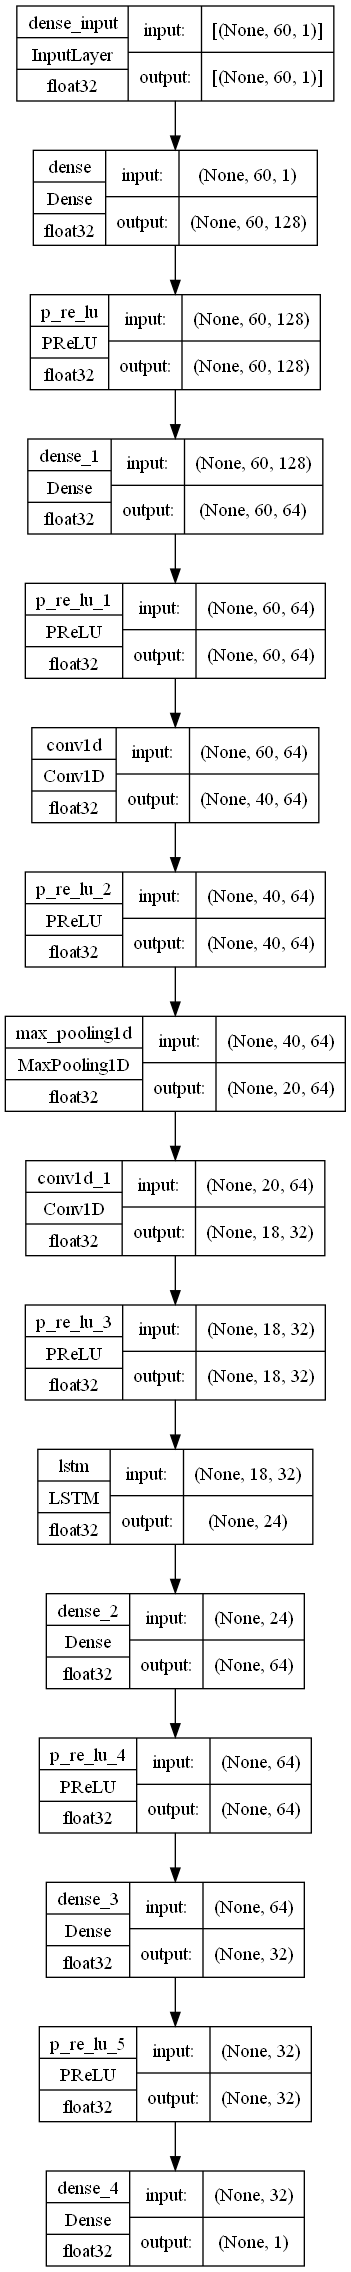

Epoch 1/10
9931/9931 [==============================] - 93s 9ms/step - loss: 0.1183 - accuracy: 0.8588 - val_loss: 0.1482 - val_accuracy: 0.8238
Epoch 2/10
9931/9931 [==============================] - 93s 9ms/step - loss: 0.1166 - accuracy: 0.8589 - val_loss: 0.1460 - val_accuracy: 0.8238
Epoch 3/10
9931/9931 [==============================] - 90s 9ms/step - loss: 0.1163 - accuracy: 0.8589 - val_loss: 0.1503 - val_accuracy: 0.8238
Epoch 3: early stopping
Model trained in 276.037569s.
This is 4.600626min.


In [17]:
############################## Machine Learing Model 1 #################################
########################################################################################
##Description: 
# Inside this code a model was created for the Machine Learning and used a convolutional 
# neural network. Besides this also the model get the is getting plotted and saved as a
# jpg. Afterwards the model is getting trained on the training data set. 
#
## This model is based on the model used in the publication:
# https://www.mdpi.com/1424-8220/22/16/6140
# This code was created with help of Bernhard Hollaus.

# Seed definition for uniqueness of models 
seed = 7
np.random.seed(seed)

# Defining the keras model
model = Sequential()

# Input layer
model.add(Dense(128, input_shape=(window_size, 1)))
model.add(PReLU()) 

# Hidden layers
model.add(Dense(64))
model.add(PReLU()) 
model.add(Conv1D(64, kernel_size=21))
model.add(PReLU()) 
model.add(MaxPooling1D())
model.add(Conv1D(32, kernel_size=3))
model.add(PReLU()) 
model.add(LSTM(24, return_sequences=False)) 
model.add(Dense(64))
model.add(PReLU()) 
model.add(Dense(32))
model.add(PReLU()) 

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
optimizer = model.optimizer

# print learning rate 
print("Learning Rate:", optimizer.learning_rate.numpy())

## Visualisation of the model and save image
# Open file dialog to select the directory and filename 
root = tk.Tk()
root.withdraw()
directory = filedialog.askdirectory()

# Getting the current time for filename
now = datetime.datetime.now()

# Give a summary of the model 
model.summary() 


# Check if the user selected a directory or canceled the dialog
if directory:
    # Construct the full file path
    file_path = f'{directory}/model_plot_{now.strftime("%m_%d_%Y_%H_%M_%S")}.png'
    
    # Plot the model and save it to the selected file
    plot_model(model, to_file=file_path, show_shapes=True, show_dtype=True,
               show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
               layer_range=None, show_layer_activations=False)
    
    # Display the saved image in the notebook
    display(Image(filename=file_path))
    
else:
    print("No directory selected.")

## Training the model with the selected data 
# Create csv logger for the machine Learning part
now = datetime.datetime.now()
csv_logger = CSVLogger('E:\Bachelorarbeit_MedTech_Sandro_Mueller\Python\ML_logs'+
                        now.strftime("%m_%d_%Y_%H_%M_%S")+'.csv', append=True, separator=';')


# Implement early stopping inside model 
es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=1, verbose=1) 

# Timer to evaluate the time it has lasted
startTime = timer()

# Fitting model to data 
history = model.fit(X_train, Y_train, epochs=10, callbacks=[es_callback,csv_logger],
                     validation_data=(X_val, Y_val), batch_size=10, verbose=1) #batch-size original 10 

# Timer to evaluate the time it has lasted
endTime = timer()
print("Model trained in {:f}s.".format(endTime - startTime))
print("This is {:f}min.".format((endTime - startTime)/60))

3104/3104 [==============================] - 14s 4ms/step
(99304,)
665/665 [==============================] - 3s 5ms/step


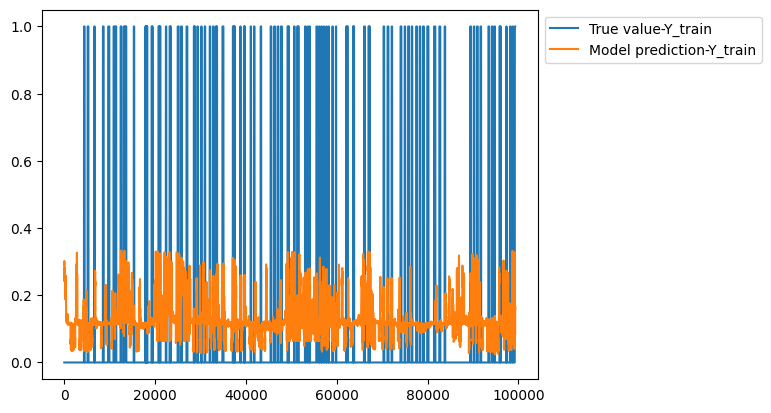

Plot 4 failed


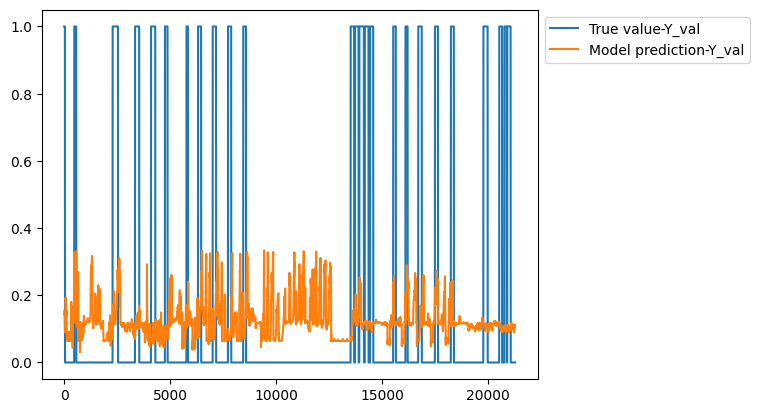

In [18]:
########################## Neural Network Evaluation ###################################
########################################################################################
##Description: 
# This code is used to evaulte the training of the neural network. Therefore a prediction 
# is getting made with the X_train set as well as with the X_val set to predict the 
# indivual Y set and plot to them beside each other inside one plot. 
#

# Evaluation of the neural network
Y_train_predict = model.predict(X_train)
Y_train_predict = np.reshape(Y_train_predict, len(Y_train_predict))
print(Y_train_predict.shape)

# Evaluation of the neural network
Y_val_predict = model.predict(X_val)
#Y_val_predict = np.reshape(Y_val_predict, len(Y_val_predict))



## Plotting the prediction values
labels = ["True value-Y_train", "Model prediction-Y_train"]
plt.plot(Y_train)
plt.plot(Y_train_predict)
plt.legend(labels, loc='upper left', bbox_to_anchor=(1,1))
plt.show()
print("Plot 4 failed")

try: 
    #Plotting
    labels = ["True value-Y_val", "Model prediction-Y_val"]
    plt.plot(Y_val)
    plt.plot(Y_val_predict)
    plt.legend(labels, loc='upper left', bbox_to_anchor=(1,1))
    plt.show()
except:
    print("Plot 4 failed")

 ResNet approach

In [ ]:
############################ Imports for the ML Model 2 ################################
########################################################################################

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import sys
import time
import statistics
import logging

from itertools import groupby
from IPython.display import display

import PIL


from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense
from tensorflow.keras.layers import ReLU, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from IPython.core.debugger import set_trace


from collections import Counter

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

In [ ]:
########################## Machine Learnign Model 2 ####################################
########################################################################################
##Description: 
# This code is used to create the second Machine Leanring Model which has the architecture
# ResNet and is used for the same purpose as the first model. This model was created with 
# the help of Bernhard Hollaus
# https://towardsdatascience.com/introduction-to-resnets-c0a830a288a4
# https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c
# https://www.researchgate.net/publication/354122252_Classification_of_Tennis_Shots_with_a_Neural_Network_Approach

# This model is based on the Links above. The structure was picked out of the publication
# This code was developed with the help of Bernhard Hollaus
########################################################################################
##################################### Functions ########################################

def read_csv(data_file_path):
    read_file = np.loadtxt(data_file_path, delimiter=",")
    time=read_file[1:,0]
    bioImpedance=read_file[1:,1]
    Label_Nothing=read_file[1:,2]
    Label_Thumb=read_file[1:,3]
    Label_Index=read_file[1:,4]
    Label_Middle=read_file[1:,5]
    Label_Ring=read_file[1:,6]
    Label_Pinki=read_file[1:,7]


    return time, bioImpedance, Label_Nothing, Label_Thumb, Label_Index, Label_Middle, Label_Ring, Label_Pinki

def data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training for sliding window approach """

    # Prepare the list for the transformed data
    X, y = list(), list()

    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps

        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break

        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[:,end_ix]

        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)

    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)

    return x_array, y_array

# Custom Callback for Confusion Matrix
class ConfusionMatrixPlotter(Callback):
    def __init__(self, X_val, y_val, class_names):
        self.X_val = X_val
        self.y_val = y_val
        self.class_names = class_names

    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X_val)
        pred_classes = np.argmax(pred, axis=1)
        true_classes = np.argmax(self.y_val, axis=1)
        cm = confusion_matrix(true_classes, pred_classes)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
########################################################################################
##################################### Processing #######################################
path=r"E:\Bachelorarbeit_MedTech_Sandro_Mueller\Data\Training_data\Measurements\labeled_controlled"
entries = os.listdir(path)
len(entries)

counter=0

for file in entries:
    #print(path+file)

    inputdata=np.array(read_csv(path+'/'+file))
    #print(inputdata.shape)
    #print(inputdata[1,:])
    if counter==0:
      X_data=inputdata[1,:]
      Y_data=inputdata[2:8,:]
    else:
      X_data=np.hstack((X_data,inputdata[1,:]))
      Y_data=np.hstack((Y_data,inputdata[2:8,:]))

    counter=counter+1

time=np.linspace(0,len(X_data)/63,len(X_data))

num_of_steps=60

X_window, Y_window = data_transform(X_data, Y_data, num_steps=num_of_steps)

train_ind1 = int(0.70 * X_window.shape[0])
train_ind2 = int(0.85 * X_window.shape[0])

X_train = X_window[:train_ind1]
Y_train = Y_window[:train_ind1]
X_val = X_window[train_ind1:train_ind2]
Y_val = Y_window[train_ind1:train_ind2]
X_test = X_window[train_ind2:]
Y_test = Y_window[train_ind2:]

# Logging configuration
path_log = "E:\\Bachelorarbeit_MedTech_Sandro_Mueller\\Python\\rats_net_log.txt"
logging.basicConfig()
fcn_logger = logging.getLogger("ResNet")
fcn_logger.setLevel(logging.INFO)

# Create file handler
f_handler = logging.FileHandler(path_log, mode='a')
f_handler.setLevel(logging.INFO)

# Create formatter and add it to handler
f_format = logging.Formatter('%(message)s')
f_handler.setFormatter(f_format)

# Create stream handler
s_handler = logging.StreamHandler(sys.stdout)
s_handler.setLevel(logging.WARNING)
s_handler.setFormatter(f_format)

# Add handler to the logger
fcn_logger.handlers = []
fcn_logger.addHandler(f_handler)
fcn_logger.addHandler(s_handler)

with tf.device('/device:GPU:0'):

    start_time_train = time.time()

    fcn_logger.info("////////////////////////////////////////////////////////////////")
    fcn_logger.info(f"{time.ctime()} - LOG")
    fcn_logger.info("****************************************************************")

    SPLITS = 4
    # StratifiedKFold ensures that the percentages of each class remains the same across all folds
    boot = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=40)

    # Track progress
    mean_benchmark = []
    mean_accuracy = []
    epochs_needed = []
    split_idx = 0
    classes = ['nothing', 'thumb', 'index', 'middle', 'ring', 'pinki'] # 0 = nothing, 1 = Thumb, 2= Index, 3=Middle, 4=Ring, 5=Pinki

    K.clear_session()

    fcn_logger.info(f"ITERATION:  {split_idx + 1}")

    for train_idx, valid_idx in boot.split(X_window, Y_window.argmax(1)):

      global model
      start_time = time.time()
      split_idx += 1

      # Split train and test
      x_train = X_window[train_idx]
      y_train = Y_window[train_idx]
      x_valid = X_window[valid_idx]
      y_valid = Y_window[valid_idx]

      #get input/output dimensions
      input_shape = x_train.shape[1:]
      nb_classes = y_train.shape[1]

      n_feature_maps = 64

      input_layer = Input(input_shape)

      # BLOCK 1

      conv_x = Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
      conv_x = BatchNormalization()(conv_x)
      conv_x = Activation('PReLU')(conv_x)

      conv_y = Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
      conv_y = BatchNormalization()(conv_y)
      conv_y = Activation('PReLU')(conv_y)

      conv_z = Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
      conv_z = BatchNormalization()(conv_z)

      # expand channels for the sum
      shortcut_y = Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
      shortcut_y = BatchNormalization()(shortcut_y)

      output_block_1 = add([shortcut_y, conv_z])
      output_block_1 = Activation('PReLU')(output_block_1)

      # BLOCK 2

      conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
      conv_x = BatchNormalization()(conv_x)
      conv_x = Activation('PReLU')(conv_x)

      conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
      conv_y = BatchNormalization()(conv_y)
      conv_y = Activation('PReLU')(conv_y)

      conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
      conv_z = BatchNormalization()(conv_z)

      # expand channels for the sum
      shortcut_y = Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
      shortcut_y = BatchNormalization()(shortcut_y)

      output_block_2 = add([shortcut_y, conv_z])
      output_block_2 = Activation('PReLU')(output_block_2)

      # BLOCK 3

      conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
      conv_x = BatchNormalization()(conv_x)
      conv_x = Activation('PReLU')(conv_x)

      conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
      conv_y = BatchNormalization()(conv_y)
      conv_y = Activation('PReLU')(conv_y)

      conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
      conv_z = BatchNormalization()(conv_z)

      # no need to expand channels because they are equal
      shortcut_y = BatchNormalization()(output_block_2)

      output_block_3 = add([shortcut_y, conv_z])
      output_block_3 = Activation('PReLU')(output_block_3)

      # FINAL

      gap_layer = GlobalAveragePooling1D()(output_block_3)

      output_layer = Dense(nb_classes, activation='softmax')(gap_layer)

      model = Model(inputs=input_layer, outputs=output_layer)

      model.compile(loss='categorical_crossentropy', optimizer="Adam",
                        metrics=['accuracy'])
      
      plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
      # Create instance for confusion matrix plott
      confusion_matrix_plotter = ConfusionMatrixPlotter(X_val=x_valid, y_val=y_valid, class_names=classes)

      monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3,
                        patience=50, verbose=0, mode='auto',
                        restore_best_weights=True)
      # Add custom callback to the list of callbacks
      callbacks_list = [monitor, confusion_matrix_plotter]

## ResNet single contraction
ResNet from above used only tuend for one contraction.. 
Not include inside Bachelor thesis because not many was changed inside this code... 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# ------------------------------------------------------------------------------
# standard modules
import sys
import time
import statistics
import logging

from itertools import groupby
from IPython.display import display

# Visualization
import PIL

# metrics and splitting
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

# keras/tensorflow modules
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense
from tensorflow.keras.layers import ReLU, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
# for dedugging
from IPython.core.debugger import set_trace

# statistics
from collections import Counter

device_name = tf.test.gpu_device_name()
print(device_name)

In [ ]:
def read_csv(data_file_path):
    read_file = np.loadtxt(data_file_path, delimiter=",")
    time=read_file[1:,0]
    bioImpedance=read_file[1:,1]
    Label_Nothing=read_file[1:,2]
    Label_Thumb=read_file[1:,3]
    Label_Index=read_file[1:,4]
    Label_Middle=read_file[1:,5]
    Label_Ring=read_file[1:,6]
    Label_Pinki=read_file[1:,7]


    return time, bioImpedance, Label_Nothing, Label_Thumb, Label_Index, Label_Middle, Label_Ring, Label_Pinki


In [ ]:
path=r"E:\Bachelorarbeit_MedTech_Sandro_Mueller\Data\Training_data\Measurements\labeled_controlled"
entries = os.listdir(path)
len(entries)

counter=0

for file in entries:
    #print(path+file)

    inputdata=np.array(read_csv(path+'/'+file))
    #print(inputdata.shape)
    #print(inputdata[1,:])
    if counter==0:
      X_data=inputdata[1,:]
      Y_data=inputdata[2:4,:]
    else:
      X_data=np.hstack((X_data,inputdata[1,:]))
      Y_data=np.hstack((Y_data,inputdata[[2,7],:])) # Get only nothing as a value 
      

    counter=counter+1


print(Y_data)
time=np.linspace(0,len(X_data)/63,len(X_data))



In [ ]:
def data_transform(x_data, y_data, num_steps=5):

    # Prepare the list for the transformed data
    X, y = list(), list()

    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps

        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break

        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[:,end_ix]

        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)

    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)

    return x_array, y_array



In [ ]:
num_of_steps=60

X_window, Y_window = data_transform(X_data, Y_data, num_steps=num_of_steps)

train_ind1 = int(0.70 * X_window.shape[0])
train_ind2 = int(0.85 * X_window.shape[0])

X_train = X_window[:train_ind1]
Y_train = Y_window[:train_ind1]
X_val = X_window[train_ind1:train_ind2]
Y_val = Y_window[train_ind1:train_ind2]
X_test = X_window[train_ind2:]
Y_test = Y_window[train_ind2:]

In [ ]:
X_window=X_window.reshape([141828,60,1])
print(X_window.shape)
print(Y_window.shape)
print(Y_data.shape)
print(np.unique(Y_window))
print(np.mean(Y_window,axis=0))

In [ ]:
# Logging configuration
path_log = "E:\\Bachelorarbeit_MedTech_Sandro_Mueller\\Python\\rats_net_log.txt"
logging.basicConfig()
fcn_logger = logging.getLogger("ResNet")
fcn_logger.setLevel(logging.INFO)

# Create file handler
f_handler = logging.FileHandler(path_log, mode='a')
f_handler.setLevel(logging.INFO)

# Create formatter and add it to handler
f_format = logging.Formatter('%(message)s')
f_handler.setFormatter(f_format)

# Create stream handler
s_handler = logging.StreamHandler(sys.stdout)
s_handler.setLevel(logging.WARNING)
s_handler.setFormatter(f_format)

# Add handler to the logger
fcn_logger.handlers = []
fcn_logger.addHandler(f_handler)
fcn_logger.addHandler(s_handler)

In [ ]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time 

# Custom Callback for Confusion Matrix
class ConfusionMatrixPlotter(Callback):
    def __init__(self, X_val, y_val, class_names):
        self.X_val = X_val
        self.y_val = y_val
        self.class_names = class_names

    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X_val)
        pred_classes = np.argmax(pred, axis=1)
        true_classes = np.argmax(self.y_val, axis=1)
        cm = confusion_matrix(true_classes, pred_classes)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

with tf.device('/device:GPU:0'):

    start_time_train = time.time()

    fcn_logger.info("////////////////////////////////////////////////////////////////")
    fcn_logger.info(f"{time.ctime()} - LOG")
    fcn_logger.info("****************************************************************")

    SPLITS = 4
    # StratifiedKFold ensures that the percentages of each class remains the same across all folds
    boot = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=40)

    # Track progress
    mean_benchmark = []
    mean_accuracy = []
    epochs_needed = []
    split_idx = 0
    classes = ['nothing', 'ring'] # 0 = nothing, 1 = Thumb, 2= Index, 3=Middle, 4=Ring, 5=Pinki

    K.clear_session()

    fcn_logger.info(f"ITERATION:  {split_idx + 1}")

    for train_idx, valid_idx in boot.split(X_window, Y_window.argmax(1)):

      global model
      start_time = time.time()
      split_idx += 1

      # Split train and test
      x_train = X_window[train_idx]
      y_train = Y_window[train_idx]
      x_valid = X_window[valid_idx]
      y_valid = Y_window[valid_idx]

      #get input/output dimensions
      input_shape = x_train.shape[1:]
      nb_classes = y_train.shape[1]

      n_feature_maps = 64

      input_layer = Input(input_shape)

      # BLOCK 1

      conv_x = Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
      conv_x = BatchNormalization()(conv_x)
      conv_x = Activation('PReLU')(conv_x)

      conv_y = Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
      conv_y = BatchNormalization()(conv_y)
      conv_y = Activation('PReLU')(conv_y)

      conv_z = Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
      conv_z = BatchNormalization()(conv_z)

      # expand channels for the sum
      shortcut_y = Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
      shortcut_y = BatchNormalization()(shortcut_y)

      output_block_1 = add([shortcut_y, conv_z])
      output_block_1 = Activation('PReLU')(output_block_1)

      # BLOCK 2

      conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
      conv_x = BatchNormalization()(conv_x)
      conv_x = Activation('PReLU')(conv_x)

      conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
      conv_y = BatchNormalization()(conv_y)
      conv_y = Activation('PReLU')(conv_y)

      conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
      conv_z = BatchNormalization()(conv_z)

      # expand channels for the sum
      shortcut_y = Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
      shortcut_y = BatchNormalization()(shortcut_y)

      output_block_2 = add([shortcut_y, conv_z])
      output_block_2 = Activation('PReLU')(output_block_2)

      # BLOCK 3

      conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
      conv_x = BatchNormalization()(conv_x)
      conv_x = Activation('PReLU')(conv_x)

      conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
      conv_y = BatchNormalization()(conv_y)
      conv_y = Activation('PReLU')(conv_y)

      conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
      conv_z = BatchNormalization()(conv_z)

      # no need to expand channels because they are equal
      shortcut_y = BatchNormalization()(output_block_2)

      output_block_3 = add([shortcut_y, conv_z])
      output_block_3 = Activation('PReLU')(output_block_3)

      # FINAL

      gap_layer = GlobalAveragePooling1D()(output_block_3)

      output_layer = Dense(nb_classes, activation='softmax')(gap_layer)

      model = Model(inputs=input_layer, outputs=output_layer)

      model.compile(loss='categorical_crossentropy', optimizer="Adam",
                        metrics=['accuracy'])
      
      plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
      
      # Create instance for confusion matrix plott
      confusion_matrix_plotter = ConfusionMatrixPlotter(X_val=x_valid, y_val=y_valid, class_names=classes)

      monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3,
                        patience=50, verbose=0, mode='auto',
                        restore_best_weights=True)
      # Add custom callback to the list of callbacks
      callbacks_list = [monitor, confusion_matrix_plotter]

      # --------------------------------------------------------------------------

      # Train on the specific fold

      print(f"Iteration #{split_idx} Training started!")

      history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                            callbacks=callbacks_list, verbose=1, epochs=1000)

      epochs = monitor.stopped_epoch
      epochs_needed.append(epochs)

      # Predict on the validation set
      pred_raw = model.predict(x_valid)

      # get the metrics
      score = metrics.log_loss(y_valid, pred_raw)
      # log loss calculcation must be done before rounding

      # set highest val to 1 others 0
      pred = np.zeros_like(pred_raw)
      pred[np.arange(len(pred_raw)), pred_raw.argmax(1)] = 1

      score_acc = metrics.accuracy_score(y_valid, pred)
      mean_benchmark.append(score)
      mean_accuracy.append(score_acc)
      m1 = statistics.mean(mean_benchmark)
      m2 = statistics.mean(epochs_needed)
      m3 = statistics.mean(mean_accuracy)
      m1dev = statistics.pstdev(mean_benchmark)
      m3dev = statistics.pstdev(mean_accuracy)


      time_took = time.time() - start_time
      fcn_logger.info(f"#{split_idx} || acc={score_acc:.3f}, mean={m3:.3f}, stdev={m3dev:.4f} || "
                      f"log_loss={score:.3f}, mean={m1:.3f}, stdev={m1dev:.4f} || "
                      f"epochs={epochs}, mean={int(m2)} || time={hms_string(time_took)}"
                      )

      class_rep = metrics.classification_report(y_valid, pred, target_names=classes)

      fcn_logger.info("****************************************************************")
      fcn_logger.info(class_rep)
      fcn_logger.info("****************************************************************")




      # Compute confusion matrix
      cm = metrics.confusion_matrix(y_valid.argmax(1), pred.argmax(1))
      np.set_printoptions(precision=2)
      # Normalize the confusion matrix by row (i.e by the number of samples
      # in each class)
      cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

      fcn_logger.info("****************************************************************")
      fcn_logger.info(np.round(cm_normalized,3))
      fcn_logger.info("****************************************************************")

      # save entire network to HDF5
      save_path = "/content/drive/MyDrive/MCI F&E mit externen/SGC_Smart_Golf_Club/ML/Network Development/Models/mynetwork.h5"
      model.save(save_path)

      # Plot fit history
      acc = history.history['accuracy']
      val_acc = history.history['val_accuracy']
      loss = history.history['loss']
      val_loss = history.history['val_loss']

      plt.figure(figsize=(8, 8))
      plt.subplot(2, 1, 1)
      plt.plot(acc, label='Training Accuracy')
      plt.plot(val_acc, label='Validation Accuracy')
      plt.legend(loc='lower right')
      plt.ylabel('Accuracy')
      plt.ylim([min(plt.ylim()),1])
      plt.title('Training and Validation Accuracy')

      plt.subplot(2, 1, 2)
      plt.plot(loss, label='Training Loss')
      plt.plot(val_loss, label='Validation Loss')
      plt.legend(loc='upper right')
      plt.ylabel('Cross Entropy')
      plt.ylim([0,1.0])
      plt.title('Training and Validation Loss')
      plt.xlabel('epoch')
      plt.show()

    total_time_training = time.time() - start_time_train
    print(f"Training finished in {hms_string(total_time_training)}")

    fcn_logger.info("****************************************************************")
    fcn_logger.info(f"Finished in {hms_string(time.time()-start_time_train)} - END")
    fcn_logger.info("****************************************************************")
